In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from datasets.datamodules import CIFAR10DataModule, GastroDataModule, DataModuleWithMasks, GenerateMasksKwargs
from lightning_modules.explainer import Explainer
from lightning_modules.surrogate import Surrogate
from vit_shapley.brute_shap import BruteShap
from vit_shapley.visualizations import get_heatmaps_grid

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(3)

In [2]:
datamodule = DataModuleWithMasks(
    # CIFAR10DataModule(),
    GastroDataModule(cropped=True),
    GenerateMasksKwargs(num_players=196),
    dict(batch_size=32)
)
datamodule.setup("test")
data = next(iter(datamodule.test_dataloader()))

images = data['image']
labels = data['label']
masks = data['mask']
segmentations = data['segmentation']
segmentations_ = (segmentations > 0).to(dtype=torch.uint8) # segmentations have a few strange values like 241
print(images.shape, labels.shape, masks.shape, segmentations.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 196]) torch.Size([32, 1, 224, 224])


In [3]:
surrogates = {
#     "vit": Surrogate.load_from_latest_checkpoint(
#     "saved_models/surrogate/gastro/v5/player196/vit_small_patch16_224",
#     map_location="cuda",
# ),
#     "t2t_vit": Surrogate.load_from_latest_checkpoint(
#     "saved_models/surrogate/gastro/v5/player196/t2t_vit_14",
#     map_location="cuda",
# ),
    "swin": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/gastro/v5/player196/swin_tiny_patch4_window7_224",
    map_location="cuda",)
}

for surrogate in surrogates.values():
    surrogate.eval()



# use_softmax = True
surrogates_prob = {}
for model_name, surrogate in surrogates.items():
    surrogates_prob[model_name] = torch.nn.Sequential(
            surrogate,
            torch.nn.Softmax(dim=1),
        )

explainers = {
    # "vit": Explainer.load_from_latest_checkpoint(
    #     "saved_models/explainer/gastro/v5/player196/vit_small_patch16_224",
    #     map_location="cuda",
    #     surrogate=deepcopy(surrogates["vit"])
    # ),
    # "t2t_vit": Explainer.load_from_latest_checkpoint(
    #     "saved_models/explainer/gastro/v5/player196/t2t_vit_14",
    #     map_location="cuda",
    #     surrogate=deepcopy(surrogates["t2t_vit"])
    # ),
    "swin": Explainer.load_from_latest_checkpoint(
        "saved_models/explainer/gastro/v5/player196/swin_tiny_patch4_window7_224",
        map_location="cuda",
        surrogate=deepcopy(surrogates["swin"]))
    # )
}
for explainer in explainers.values():
    explainer.eval()

# for explainer in explainers.values():
#     assert explainer.hparams["use_softmax"] == use_softmax

# print(use_softmax)

In [4]:
# For each explainer a tensor of shape (len(images), num_players, num_classes).
shap_values = dict[str, torch.Tensor]()

In [5]:
for name, explainer in explainers.items():
    with torch.no_grad():
        shap_values[name] = explainer(images.cuda()).cpu()  # shape (len(images), num_players, num_classes).

In [6]:
# Limit to target class.
target_shap_values = dict[str, torch.Tensor]()
for name in shap_values.keys():
    target_shap_values[name] = shap_values[name][torch.arange(len(images)), :, labels]  # shape (len(images), num_players).

In [7]:
from torchmetrics.classification import Dice
dice_score = Dice().cuda()

def rescale_explainer(model_name):
    outputs_for_targets = explainers[model_name](images.to(explainers[model_name].device))[torch.arange(len(images)), :, labels].detach()
    outputs_reshaped = outputs_for_targets.view(-1, 1, 14, 14).repeat_interleave(16, dim=2).repeat_interleave(16,dim=3)
    return outputs_reshaped

def compute_metrics(metric, 
                    model_name: str, 
                    images: torch.Tensor, 
                    threshold: torch.Tensor):
    explainer_outputs = rescale_explainer(model_name)
    explainer_segmentation = explainer_outputs > threshold
    return explainer_outputs, explainer_segmentation, metric(explainer_segmentation, segmentations_.to(explainer_outputs.device))

## Dice scores

In [ ]:
dice_scores = []
arg_max_score = 0 
max_score = 0
for i in range(50):
    explainer_outputs, explainer_segmentation, dice_score_ = compute_metrics(dice_score, "vit", images, 0.02*i)
    dice_scores.append(dice_score_.cpu().detach().numpy())
    if dice_score_ > max_score:
        arg_max_score = i
        max_score = dice_score_


print(f"it was obtained for the threshold {0.02*arg_max_score}")
print(max_score)


In [ ]:
dice_scores = []
arg_max_score = 0 
max_score = 0
for i in range(50):
    explainer_outputs, explainer_segmentation, dice_score_ = compute_metrics(dice_score, "t2t_vit", images, 0.02*i)
    dice_scores.append(dice_score_.cpu().detach().numpy())
    if dice_score_ > max_score:
        arg_max_score = i
        max_score = dice_score_


print(f"it was obtained for the threshold {0.02*arg_max_score}")
print(max_score)

In [49]:
dice_scores = []
arg_max_score = 0 
max_score = 0
for i in range(50):
    explainer_outputs, explainer_segmentation, dice_score_ = compute_metrics(dice_score, "swin", images, -0.3 + 0.02*i)
    dice_scores.append(dice_score_.cpu().detach().numpy())
    if dice_score_ > max_score:
        arg_max_score = i
        max_score = dice_score_


print(f"it was obtained for the threshold {0.02*arg_max_score}")
print(max_score)

it was obtained for the threshold 0.4
tensor(0.8725, device='cuda:0')


In [70]:
explainer_outputs, explainer_segmentation_max, dice_score_max = compute_metrics(dice_score, "swin", images, 0.2)

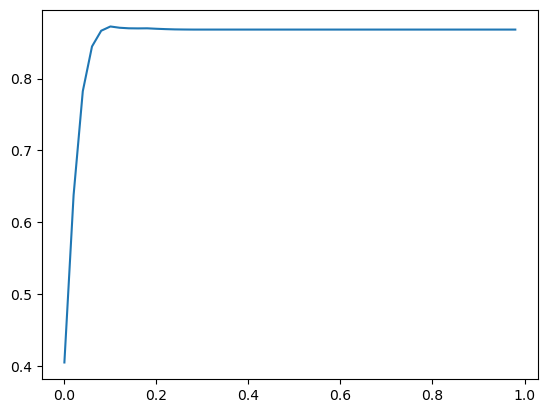

In [11]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = 0.02*np.arange(50)
ypoints = np.array(dice_scores)

plt.plot(xpoints, ypoints)
plt.show()

## Jaccard Index

In [34]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task="multiclass", num_classes=2).cuda()


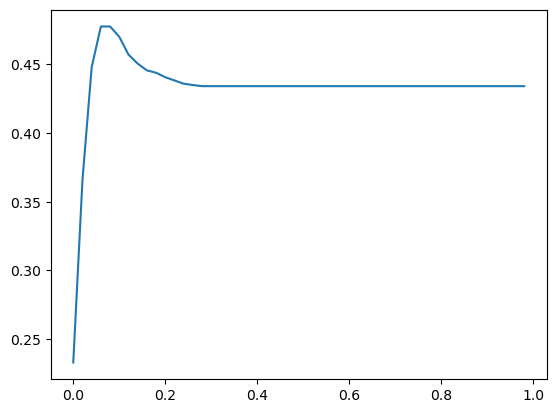

In [74]:
jaccard_scores = []
for i in range(50):
    explainer_outputs, explainer_segmentation, jaccard_score_ = compute_metrics(jaccard, "swin", images, 0.02*i)
    jaccard_scores.append(jaccard_score_.cpu().detach().numpy())


xpoints = 0.02*np.arange(50)
ypoints = np.array(jaccard_scores)

plt.plot(xpoints, ypoints)
plt.show()

In [76]:
jaccard_scores = []
arg_max_score = 0 
max_score = 0

for i in range(50):
    explainer_outputs, explainer_segmentation, jaccard_score_ = compute_metrics(jaccard, "swin", images, -0.3 + 0.02*i)
    jaccard_scores.append(jaccard_score_.cpu().detach().numpy())
    if jaccard_score_ > max_score:
        arg_max_score = i
        max_score = jaccard_score_


print(f"it was obtained for the threshold {0.02*arg_max_score}")
print(max_score)

it was obtained for the threshold 0.38
tensor(0.4775, device='cuda:0')


In [77]:
explainer_outputs, explainer_segmentation_max, jaccard_score_max = compute_metrics(jaccard, "swin", images, 0.38)

In [78]:
explainer_segmentation_max.float().mean()

tensor(0., device='cuda:0')

## Visualize Shapley values with segmentation

In [15]:
indices = labels == 1
indices
images[indices].shape

torch.Size([19, 3, 224, 224])

In [16]:
import torchvision

polyp_indices = labels == 1

polyp_images = []

for i, polyp_idx in enumerate(polyp_indices):
    if polyp_idx:
        polyp_image = get_heatmaps_grid(images[i].unsqueeze(0), labels[i].unsqueeze(0), classes=["no", "polyp"], shap_values=target_shap_values["swin"][i].unsqueeze(0), n_columns=1, alpha=0.6, scale=1)
        polyp_images.append(polyp_image)

min=-0.040, max=0.212
min=-0.027, max=0.094
min=-0.030, max=0.148
min=-0.088, max=0.118
min=-0.058, max=0.137
min=-0.061, max=0.054
min=-0.067, max=0.061
min=-0.054, max=0.272
min=-0.071, max=0.080
min=-0.067, max=0.236
min=-0.089, max=0.146
min=-0.040, max=0.102
min=-0.028, max=0.125
min=-0.078, max=0.218
min=-0.054, max=0.074
min=-0.065, max=0.112
min=-0.065, max=0.061
min=-0.035, max=0.231
min=-0.035, max=0.128


In [17]:
polyp_images = [torchvision.transforms.functional.pil_to_tensor(polyp_image) for polyp_image in polyp_images]

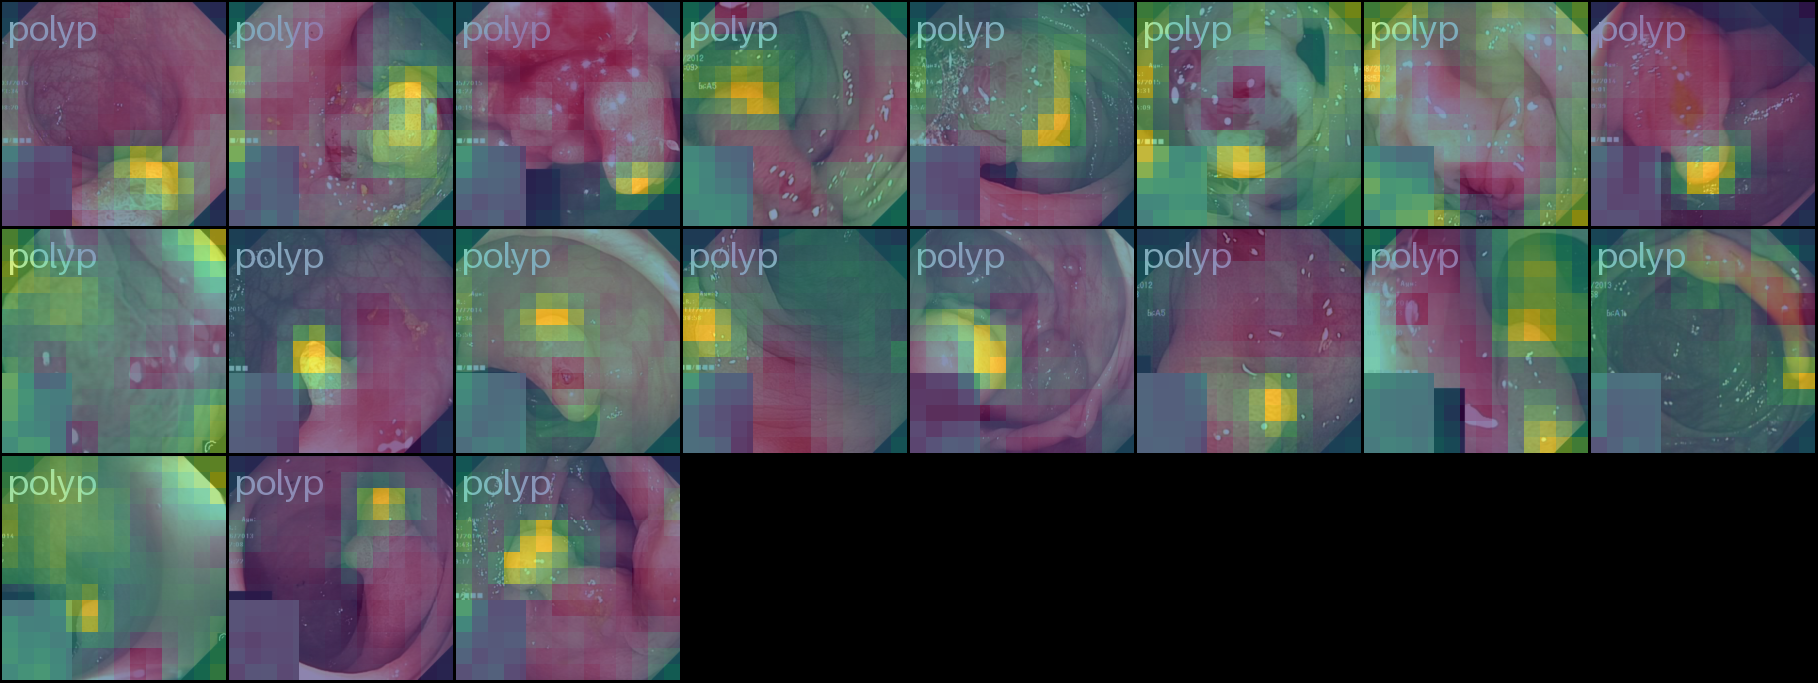

In [18]:
# img = segmentations_[0].reshape(224,224,1)
# plt.imshow(img.numpy())
from torchvision.utils import make_grid 

Grid = make_grid(polyp_images)

# display result 
img = torchvision.transforms.ToPILImage()(Grid) 
img.show() 

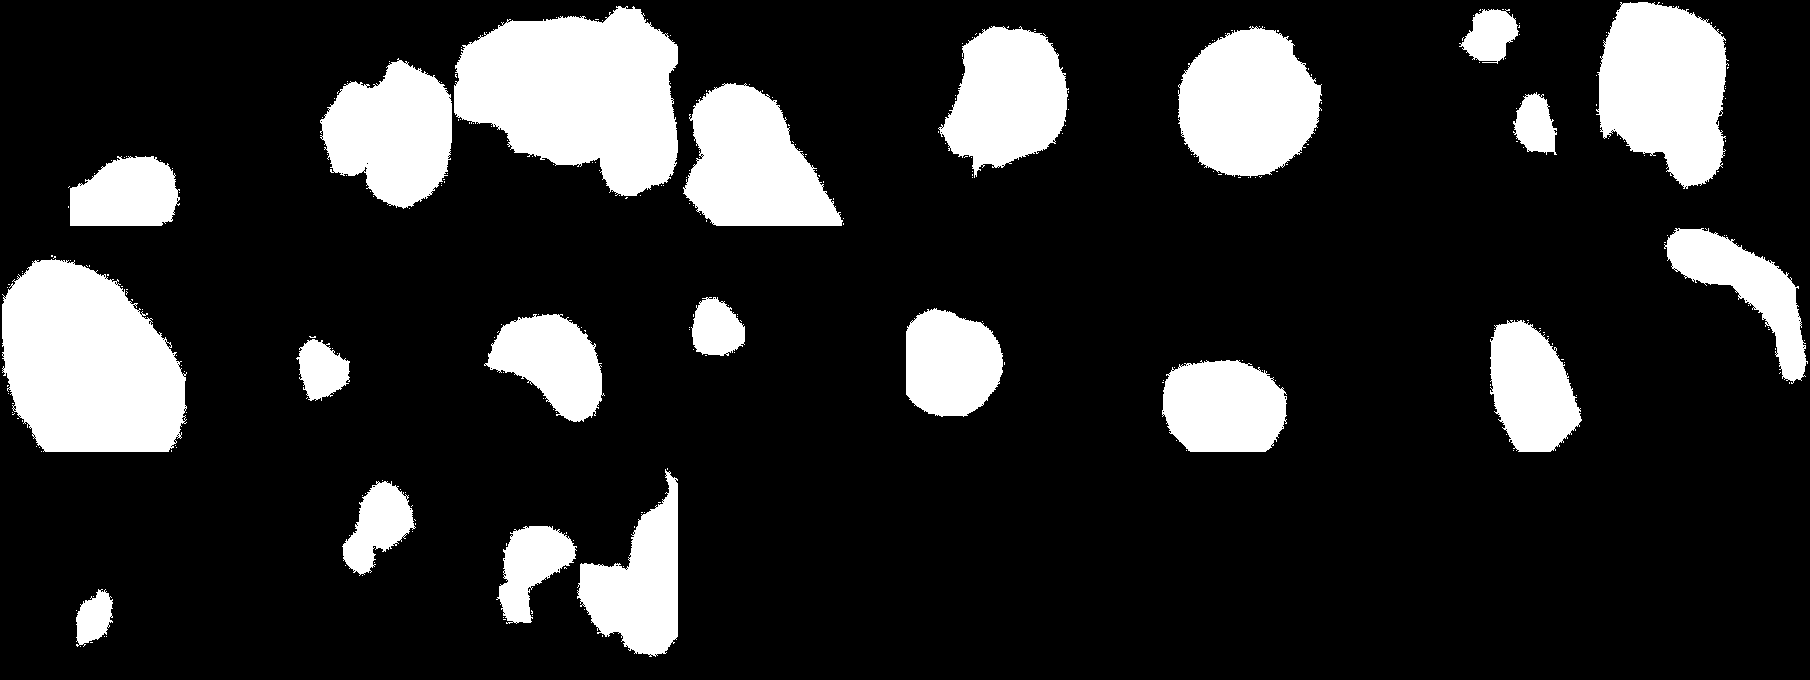

In [12]:
Grid_segm = make_grid(segmentations_[polyp_indices].float())

# display result 
img = torchvision.transforms.ToPILImage()(Grid_segm) 
img.show() 

In [116]:
x.dtype

torch.uint8

In [26]:
explainer_segmentation_max.shape

torch.Size([32, 1, 224, 224])

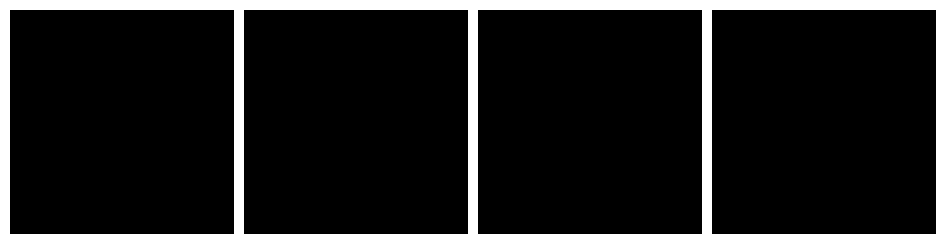

In [24]:
Grid_four_explainer_segmentations = make_grid(explainer_segmentation_max[polyp_indices][:4].float(), padding=10, pad_value=1)
img = torchvision.transforms.ToPILImage()(Grid_four_explainer_segmentations) 
img.show()

In [ ]:
Grid_four_images = make_grid(images[polyp_indices][:4].to(dtype=torch.uint8), padding=10, pad_value=1)

img = torchvision.transforms.ToPILImage()(Grid_four_images) 
img.show()

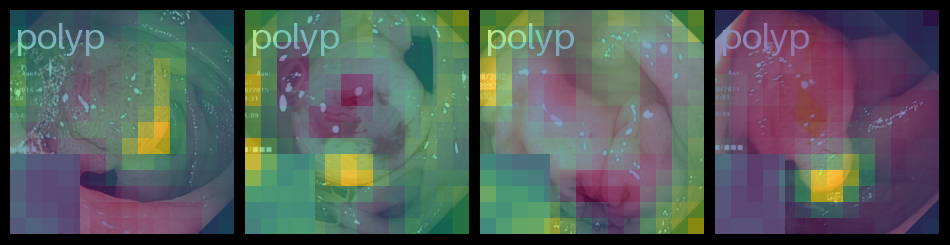

In [222]:
Grid_four_shap = make_grid(polyp_images[4:8], padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_shap) 
img.show()

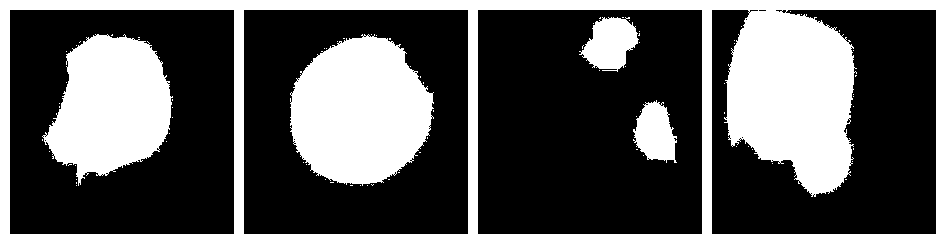

In [215]:
Grid_four_segm = make_grid(segmentations_[polyp_indices][4:8].repeat(1,3,1,1).float(), padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_segm) 
img.show()

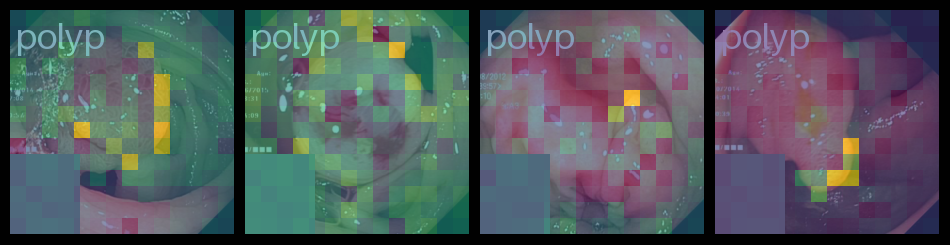

In [207]:
Grid_four_shap = make_grid(polyp_images[4:8], padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_shap) 
img.show()

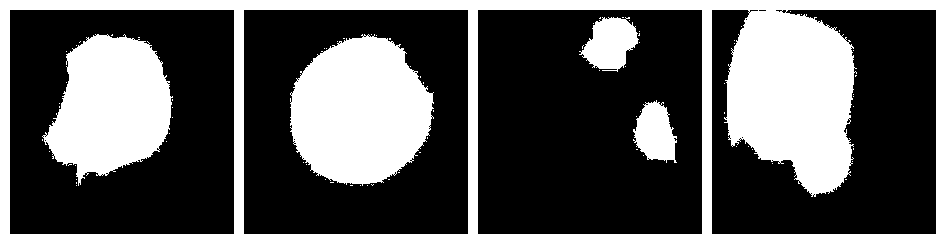

In [208]:
Grid_four_segm = make_grid(segmentations_[polyp_indices][4:8].repeat(1,3,1,1).float(), padding=10, pad_value=1)

# display result 
img = torchvision.transforms.ToPILImage()(Grid_four_segm) 
img.show()